/home/m/m300872/.local/lib/python3.9/site-packages/pint/facets/plain/quantity.py:1374: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = new_self._magnitude**exponent


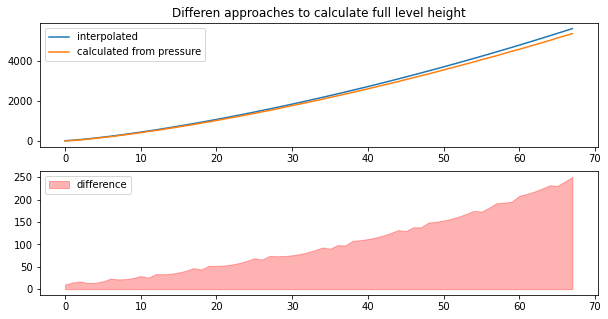

In [1]:
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import eurec4a
import matplotlib.pyplot as plt

def hydrostatic_profile(h, p_surf=100000):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def pres2heigth(p, max_height=50000, meter_per_level=1):
    h = np.linspace(0,max_height, int(max_height/meter_per_level))
    p_ref = hydrostatic_profile(h, p[0])
    h = np.asarray([h[nearest_value_index(p_ref, value)] for value in p])
    return h

def print_table(a,b,col_width=10):
    if not len(a) == len(b): raise ValueError("Arrays have different size.")
    for i in range(len(a)):
        print(str(i).ljust(3), f'{a[i]:.2f}'.rjust(col_width), f'{b[i]:.2f}'.rjust(col_width))
        
data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['3D_DOM01'].to_dask().isel(time=0).mean(dim='cell')
vgrid = eurec4a.get_intake_catalog().simulations.grids['ecf22d17-dcee-1510-a807-11ae4a612be0'].to_dask().mean(dim='cell')

# vgrid.mean(dim='cell')['z_ifc'].values, vgrid.median(dim='cell')['z_ifc'].values 
model_p = np.flip(np.ravel(data['pres'].values))
h_from_p = pres2heigth(model_p, meter_per_level=10)
h_interpol = interpolate_full_level(np.flip(vgrid['z_ifc'].values))[0:len(h_from_p)]
x = range(len(h_from_p))
fig, axs = plt.subplots(2,1, figsize=(10,5))
ax = axs[0]
ax.plot(x,h_interpol, label='interpolated')
ax.plot(x,h_from_p,   label='calculated from pressure')
ax.legend()
ax.set_title('Different approaches on calculating full level height')
ax = axs[1]
ax.fill_between(x,h_interpol-h_from_p, color='red', alpha=0.3, label='difference')
ax.legend(loc='upper left')
plt.show()